In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [6]:
# Dummy data to test
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-02'),
    first_days=5,
    split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [9]:
# Using first month of 2020, eventually use all of 2020
ds_test = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-01'),
    mins=ds_train.mins,
    maxs=ds_train.maxs
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [10]:
sampler_train = torch.utils.data.WeightedRandomSampler(
    ds_train.compute_weights(), len(ds_train)
)

In [12]:
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=32, sampler=sampler_train
)

In [15]:
gen = Generator(
    nres=3, nf_in=1, nf=32, use_noise=True
).to(device)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [17]:
trainer = Trainer(gen, optimizer, criterion, dl_train)

In [18]:
trainer.fit(1)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


KeyboardInterrupt: 

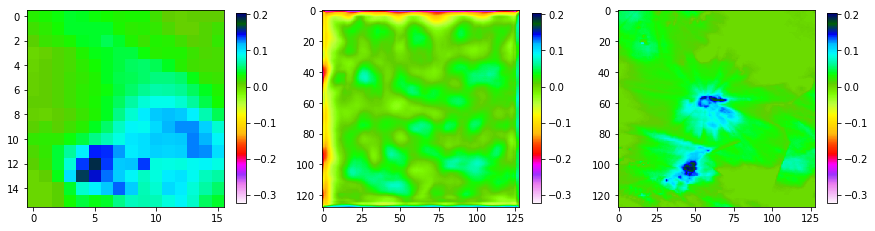

In [19]:
X, y = next(iter(dl_train))
plot_sample(X, y, gen, 0)

In [ ]:
plot_sample(X, y, gen, 0)

## Evaluation

In [ ]:
# Note that we are using xarray datasets for handling our data!
# This makes things SO MUCH easier :)
def create_valid_predictions(model, ds_valid):
    # Get predictions for full field
    preds = []
    for t in tqdm.tqdm(range(len(ds_valid.tigge.valid_time))):
        X, y = ds_valid.return_full_array(t)
        pred = model(torch.FloatTensor(X[None]).to(device)).to('cpu').detach().numpy()[0, 0]
        preds.append(pred)
    preds = np.array(preds)
    
    # Unscale
    preds = preds * (ds_valid.maxs.tp.values - ds_valid.mins.tp.values) + ds_valid.mins.tp.values
    
    # Convert to xarray
    preds = xr.DataArray(
        preds,
        dims=['valid_time', 'lat', 'lon'],
        coords={
            'valid_time': ds_valid.tigge.valid_time,
            'lat': ds_valid.mrms.lat.isel(lat=slice(0, preds.shape[1])),
            'lon': ds_valid.mrms.lon.isel(lon=slice(0, preds.shape[2]))
        },
        name='tp'
    )
    return preds